In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

## Test embedding net

In [5]:
! which python

/Users/smsharma/anaconda3/bin/python


In [6]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [7]:
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

In [8]:
ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2,
                              mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

torch.Size([1, 16384, 1])

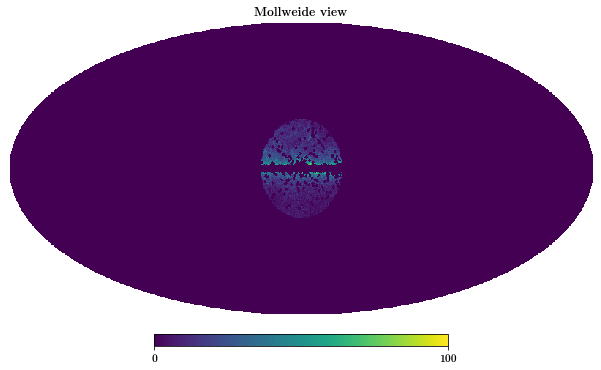

In [9]:
in_map = np.load("../data/fermi_data/fermidata_counts.npy")
in_map[hp_mask] = 0

hp.mollview(in_map, max=100)

in_map = torch.Tensor(in_map[~masks_list[0]])
in_map = in_map.reshape((1, -1, 1))
in_map.shape

In [10]:
log_mean = torch.log(torch.mean(in_map))
log_std = torch.log(torch.var(in_map).sqrt())

log_mean = log_mean.reshape((1, -1, 1))
log_std = log_std.reshape((1, -1, 1))

data_map = torch.cat([in_map, log_mean, log_std], axis=1)[:, :, 0]
data_map.shape

torch.Size([1, 16386])

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [12]:
sg = SphericalGraphCNN(nside_list, indexes_list, n_aux_var=2).to(device)

In [150]:
sg(data_map).shape

torch.Size([1, 96])

## Test data generation

In [14]:
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF

In [15]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [16]:
from simulations.wrapper import simulator

In [17]:
import sys
from sbi import utils
from sbi import inference

In [23]:
# Load templates
temp_gce = np.load("../data/fermi_data/template_gce.npy")
temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk = np.load("../data/fermi_data/template_dsk.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')


fermi_exp = np.load("../data/fermi_data/fermidata_exposure.npy")

# iso, bub, psc, dif
prior_poiss = [[0.001, 0.001, 0.001, 6., 1.], [1.5, 1.5, 1.5, 12., 6.]]

# gce, dsk
prior_ps = [[0.001, 10.0, 1.1, -10.0, 5.0, 0.1, 0.001, 10.0, 1.1, -10.0, 5.0, 0.1], [0.5, 20.0, 1.99, 1.99, 50.0, 4.99, 0.5, 20.0, 1.99, 1.99, 50.0, 4.99]]

prior = utils.BoxUniform(low=torch.tensor([0.001] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.5] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((1,))

ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
roi_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25, custom_mask=ps_mask)

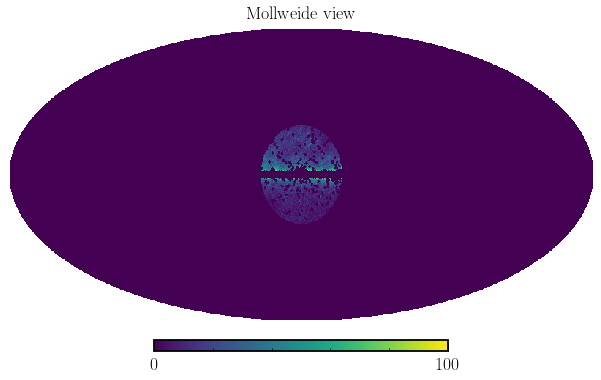

In [100]:
# simulator(theta, temps_poiss, temps_ps, mask_sim, mask_roi, norm=False)

theta = thetas[0]

temps_poiss = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps = [temp_gce, temp_dsk]

test_map_temp = simulator(theta.detach().numpy(), temps_poiss, temps_ps, masks_list[0], roi_mask, pc_inst.psf_r_func)
test_map = np.zeros(hp.nside2npix(128))
test_map[np.where(~masks_list[0])] = test_map_temp[0, :-2]
hp.mollview(test_map, max=100)

In [27]:
test_map_temp[0, -2:]

array([1.96317066, 2.43823314])

In [30]:
from tqdm import *

In [35]:
sg_embed = SphericalGraphCNN(nside_list, indexes_list)

## SNPE

In [36]:
# from sbi.inference import SNPE
from sbi.inference import PosteriorEstimator
from sbi import utils
from sbi import inference

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [38]:
# iso, bub, psc, dif_pibrem, dif_ics
prior_poiss = [[0.001, 0.001, 0.001, 6., 1.], [1.5, 1.5, 1.5, 12., 6.]]

# gce, dsk
prior_ps = [[0.001, 10.0, 1.1, -10.0, 5.0, 0.1, 0.001, 10.0, 1.1, -10.0, 5.0, 0.1], [2., 20.0, 1.99, 1.99, 50.0, 4.99, 2., 20.0, 1.99, 1.99, 50.0, 4.99]]

# Combine priors
prior = utils.BoxUniform(low=torch.tensor([0.001] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([2.] + prior_poiss[1] + prior_ps[1]))

In [39]:
# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=sg_embed,
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure with the SNPE-C procedure
inference_inst = PosteriorEstimator(prior=prior, density_estimator=neural_classifier, 
                           show_progress_bars=True,
                           logging_level='INFO',
                          device=device.type)

In [40]:
# density_estimator = inference_inst.train(x="/scratch/sm8383/sbi-fermi/data/samples/x_small_train.npy",
#                                          theta="/scratch/sm8383/sbi-fermi/data/samples/theta_small_train.npy",
#                                          proposal=prior,
#                                          training_batch_size=100, max_num_epochs=50)

In [41]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

In [42]:
run_id = '341be6f12e354e3b814e386988e729a7'

data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-fermi/data/logs/mlruns/0/' + run_id + '/artifacts/density_estimator')

2021/01/07 10:06:57 WARNING mlflow.pytorch: Stored model version '1.7.0' does not match installed PyTorch version '1.6.0'


In [43]:
# density_estimator = torch.load("../data/models/vanilla_dif.pt", map_location=torch.device('cpu'))

In [44]:
from sbi.utils import x_shape_from_simulation

x_presimulated = torch.Tensor(np.load("../data/samples/x_train_float_all_ModelO_33.npy"))
theta_presimulated = torch.Tensor(np.load("../data/samples/theta_train_float_all_ModelO_33.npy"))

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)

In [45]:
posterior = inference_inst.build_posterior(density_estimator)

In [46]:
import corner

In [82]:
# iso, bub, psc, dif_pibrem, dif_ics
prior_poiss = [[0.9, 0.09, 0.6, 7.5, 3.], [1.1, 0.11, 0.9, 8.5, 4.]]

# gce, dsk
prior_ps = [[0.001, 10.0, 1.1, -10.0, 5.0, 0.1, 0.001, 10.0, 1.1, -10.0, 5.0, 0.1], [2., 20.0, 1.99, 1.99, 50.0, 4.99, 2., 20.0, 1.99, 1.99, 50.0, 4.99]]

# Combine priors
prior_sim = utils.BoxUniform(low=torch.tensor([0.001] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([2.] + prior_poiss[1] + prior_ps[1]))

In [98]:
theta_presimulated[0]

tensor([ 1.7432,  1.0363,  0.0963,  0.6862,  7.9016,  3.6372,  0.2027, 11.5437,
         1.7928, -5.6381, 46.4872,  0.3856,  0.9433, 13.4657,  1.7884, -4.8913,
        38.5267,  4.0829])

In [101]:
n_sim = 5
theta_presimulated = prior_sim.sample((n_sim,))
x_presimulated = [simulator(theta.detach().numpy(), temps_poiss, temps_ps, masks_list[0], roi_mask, pc_inst.psf_r_func) for theta in tqdm_notebook(theta_presimulated)]

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/5 [00:00<?, ?it/s]

In [102]:
x_presimulated = torch.Tensor(x_presimulated)

In [103]:
x_presimulated[0].view(-1, 16386, 1).shape

torch.Size([1, 16386, 1])

In [104]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [105]:
def dnds_conv(s_ary, theta):
    dnds_ary = dnds(s_ary, [1] + list(theta[1:]))
    A = theta[0] / np.trapz(s_ary * dnds_ary, s_ary)
    dnds_ary = dnds(s_ary, [A] + list(theta[1:]))
    return dnds_ary

In [106]:
poiss_labels = [r"iso", r"bub", r"psc", r"pibrem", r"ics"]
ps_labels = [r"gce ps", r"dsk ps"]
temps_poiss = [temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps = [temp_gce, temp_dsk]

In [107]:
from getdist import plots, MCSamples
import getdist


In [108]:
torch.median(posterior_samples, axis=0)

torch.return_types.median(
values=tensor([ 1.0353,  0.1789,  0.7432,  0.7704,  8.1011,  3.4358,  0.2648, 15.0865,
         1.5694, -3.6769, 12.2610,  2.1655,  1.0243, 15.0302,  1.6604, -3.6149,
        13.0175,  2.0737]),
indices=tensor([5394, 2116, 5607, 8142, 5486, 9843, 2290, 3288, 8667,   99, 4881, 2093,
        5318, 1665, 2494,  550, 4253, 7529]))

In [134]:
def get_signal_injection(coeff, plot_map=False):
    in_map = np.load("../data/fermi_data/fermidata_counts.npy") + coeff * np.random.poisson(temp_gce)
    in_map[hp_mask] = 0
    
    if plot_map:
        hp.mollview(in_map, max=100)

    in_map = torch.Tensor(in_map[~masks_list[0]])
    in_map = in_map.reshape((1, -1, 1))

    log_mean = torch.log(torch.mean(in_map))
    log_std = torch.log(torch.var(in_map).sqrt())

    log_mean = log_mean.reshape((1, -1, 1))
    log_std = log_std.reshape((1, -1, 1))

    data_map = torch.cat([in_map, log_mean, log_std], axis=1)[:, :, 0]
    
    return data_map

In [137]:
coeff_ary = np.linspace(0, 0.9, 5)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


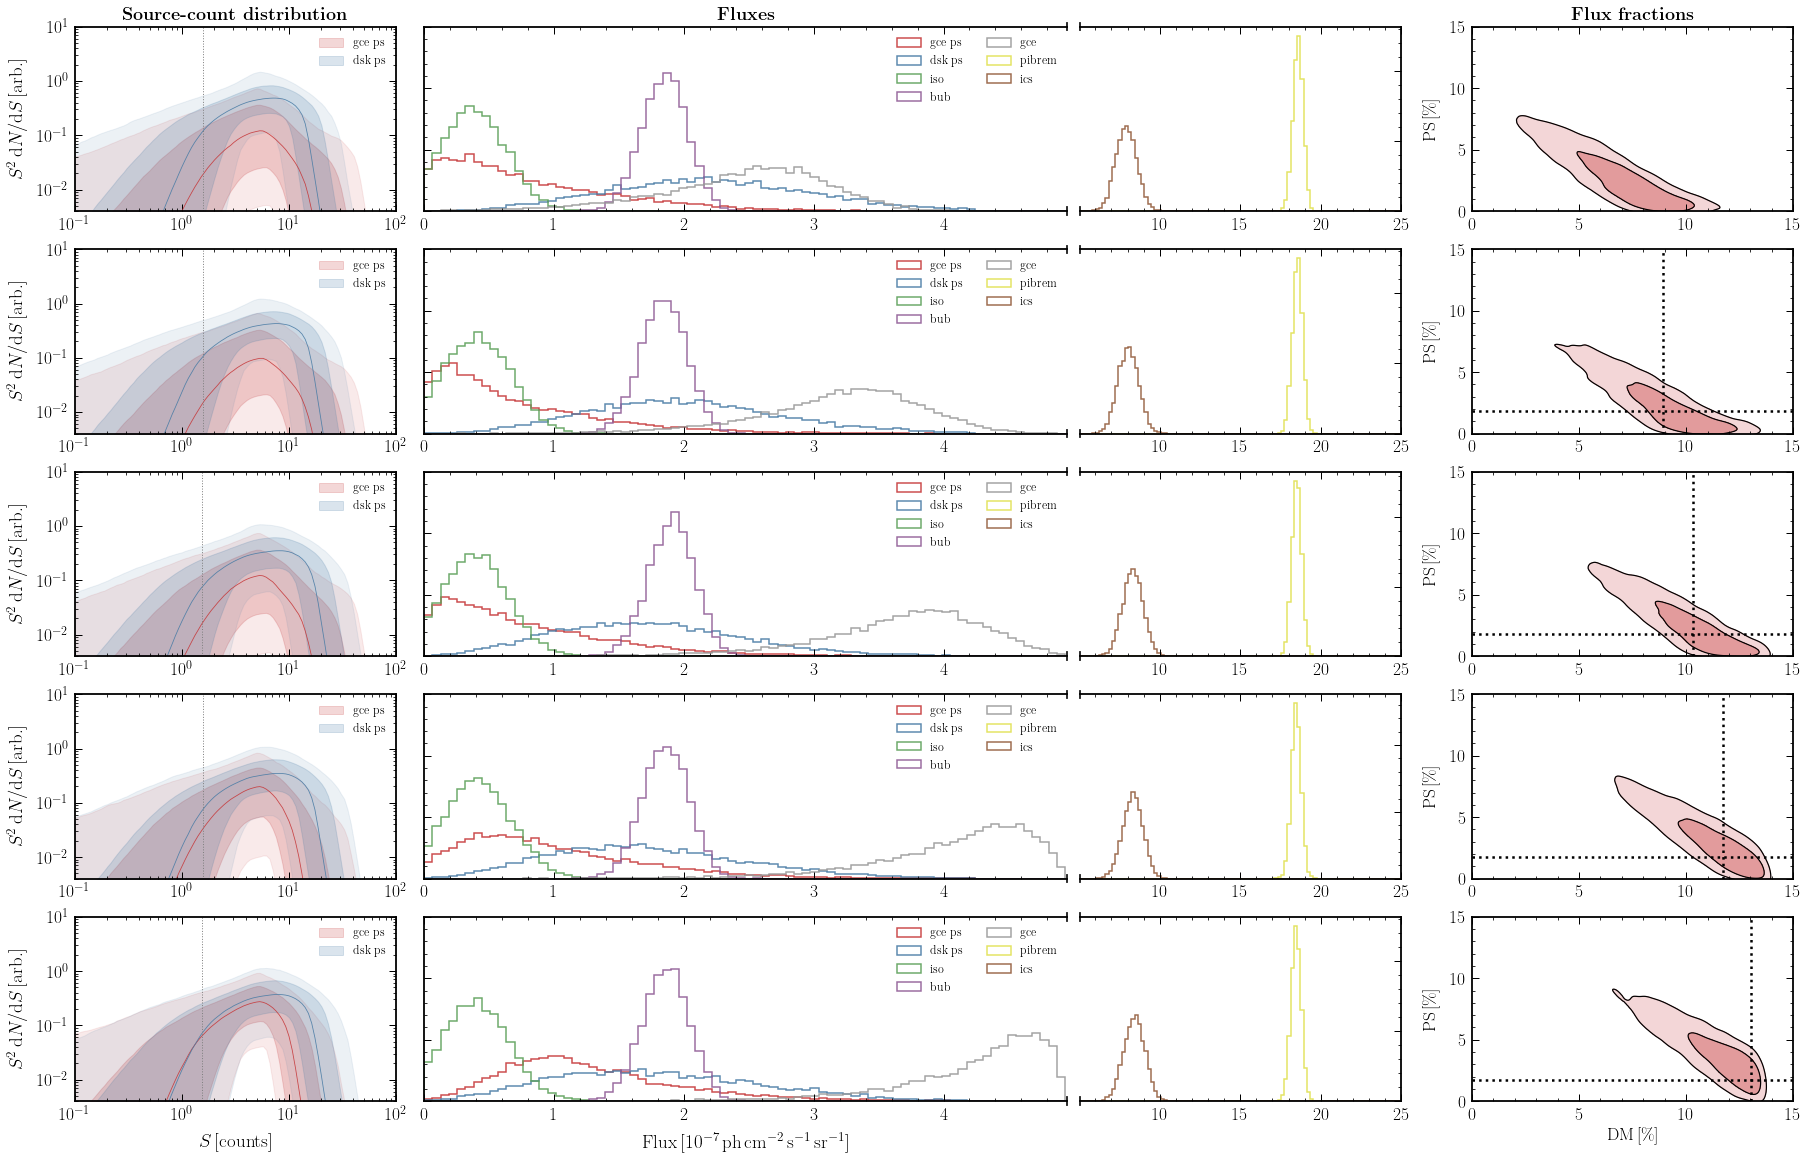

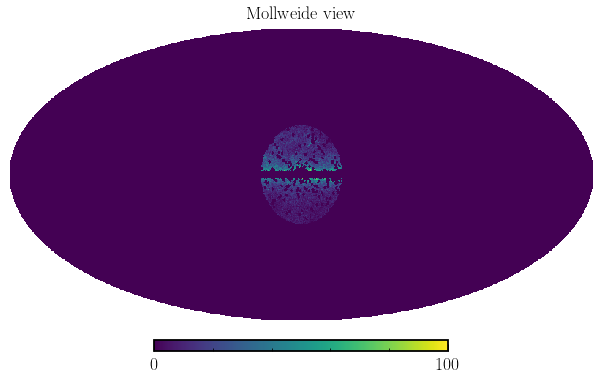

<Figure size 432x324 with 0 Axes>

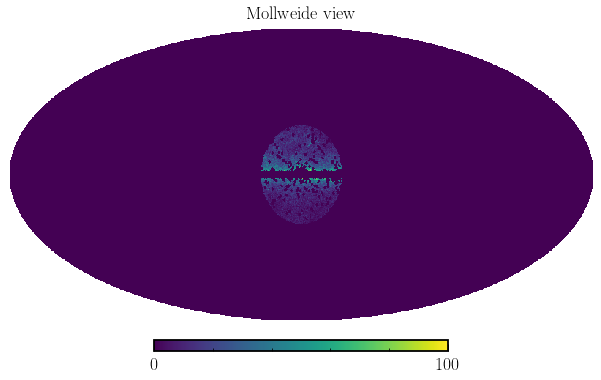

<Figure size 432x324 with 0 Axes>

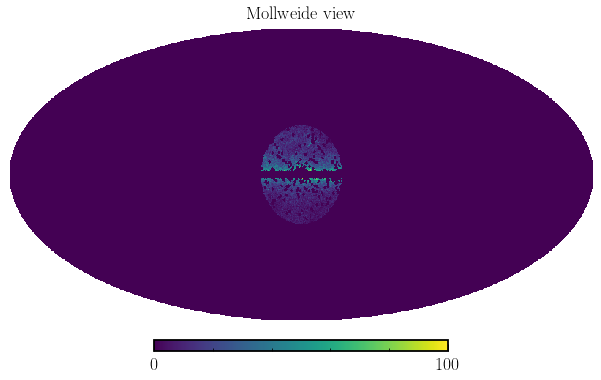

<Figure size 432x324 with 0 Axes>

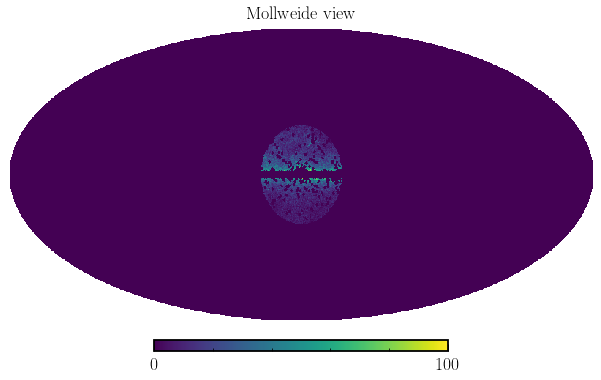

<Figure size 432x324 with 0 Axes>

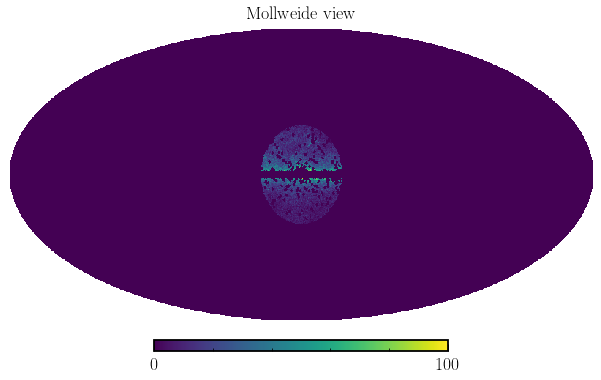

<Figure size 432x324 with 0 Axes>

In [141]:
pixarea = hp.nside2pixarea(128, degrees=False)

nrows = 5
idx_start = 0
# fig, ax = plt.subplots(ncols=4, nrows=nrows, constrained_layout=True, figsize=(20, 15))

fig = plt.figure(constrained_layout=True, figsize=(25, 16))
gs = fig.add_gridspec(nrows=nrows, ncols=5)

ax = [[None] * 5] * nrows

for i_r in range(nrows):
    
    truth_idx = idx_start + i_r
    
    theta_truth = theta_presimulated[truth_idx]
    x_o = x_presimulated[truth_idx]
    
#     if i_r == nrows - 1:
#         x_o = data_map
#         is_data = True
#     else:
#         is_data = False
    
    is_data = True
    signal_injection = True
    x_o = get_signal_injection(coeff_ary[i_r])
        
    posterior_samples = posterior.sample((10000,), x=x_o)

    s_ary = np.logspace(-1, 2, 100)
    
    ax[i_r][0] = fig.add_subplot(gs[i_r,0])
    
    for idx_ps, i_param_ps in enumerate([6, 12]):
        dnds_ary = [dnds_conv(s_ary, theta) for theta in posterior_samples[:,i_param_ps:i_param_ps+6].detach().numpy()]

        ax[i_r][0].plot(s_ary, np.median(s_ary ** 2 * dnds_ary, axis=0), color=cols_default[idx_ps], lw=0.8)
        ax[i_r][0].fill_between(s_ary, np.percentile(s_ary ** 2 * dnds_ary, [16], axis=0)[0], np.percentile(s_ary ** 2 * dnds_ary, [84], axis=0)[0], alpha=0.2, color=cols_default[idx_ps], label=ps_labels[idx_ps])
        ax[i_r][0].fill_between(s_ary, np.percentile(s_ary ** 2 * dnds_ary, [2.5], axis=0)[0], np.percentile(s_ary ** 2 * dnds_ary, [97.5], axis=0)[0], alpha=0.1, color=cols_default[idx_ps])
        
        
        if not is_data:
            ax[i_r][0].plot(s_ary, s_ary ** 2 * dnds_conv(s_ary, theta_truth[i_param_ps:i_param_ps+6].detach().numpy()), color=cols_default[idx_ps], ls='dotted', label=ps_labels[idx_ps] + " truth")
    
    ax[i_r][0].set_xscale("log")
    ax[i_r][0].set_yscale("log")

    ax[i_r][0].set_ylim(4e-3, 1e1)
    ax[i_r][0].set_xlim(1e-1, 1e2)
    
    ax[i_r][0].axvline(np.sqrt(x_presimulated[truth_idx,0,-1]), lw=1, ls='dotted', color='grey')
    
    ax[i_r][0].set_ylabel(r"$S^2\,\mathrm{d}N/\mathrm{d}S$\,[arb.]")
    
    if i_r == nrows - 1:
        ax[i_r][0].set_xlabel(r"$S$\,[counts]")
     
    if i_r == 0:
        ax[i_r][0].set_title(r"\bf{Source-count distribution}")

    ax[i_r][0].legend(fontsize=12)
        
    
    ax[i_r][1] = fig.add_subplot(gs[i_r,-1])
        
    x_embedded = np.zeros(hp.nside2npix(128))
    x_embedded[np.where(~masks_list[0])] = x_o[0, :-2]
    mean_roi_counts = np.mean(x_embedded[~roi_mask])
    
    fraction_multiplier = 100 * np.mean(temps_ps[0][~roi_mask]) / np.mean(temps_ps[0][~masks_list[0]]) / mean_roi_counts
    
    g = plots.get_single_plotter()
    samples = MCSamples(samples=np.transpose(np.array([posterior_samples[:, 0].detach().numpy() * fraction_multiplier, posterior_samples[:, 6].detach().numpy() * fraction_multiplier])),names = ['blah','blah1'], labels = ['blah','blah1'])
    g.plot_2d(samples, 'blah', 'blah1', filled=True, alphas=[0.5], ax=ax[i_r][1], colors=[cols_default[0]])
    g.plot_2d(samples, 'blah', 'blah1', filled=False, ax=ax[i_r][1], colors=['k'], lws=[1.2])
    
#     an.plot.kde_contour_plot_2d(ax[i_r][1], posterior_samples[:, 0].detach().numpy() * fraction_multiplier, posterior_samples[:, 6].detach().numpy() * fraction_multiplier)
#     corner.hist2d(posterior_samples[:, 0].detach().numpy() * fraction_multiplier, posterior_samples[:, 6].detach().numpy() * fraction_multiplier, ax=ax[i_r][1], smooth=1.)


    if signal_injection:
        if i_r == 0:
            theta_dm_baseline = np.median(posterior_samples[:, 0].detach().numpy())
            theta_ps_baseline = np.median(posterior_samples[:, 6].detach().numpy())
        else:
            
            ax[i_r][1].axvline((theta_dm_baseline + coeff_ary[i_r]) * fraction_multiplier, color='k', ls='dotted')
            ax[i_r][1].axhline((theta_ps_baseline) * fraction_multiplier, color='k', ls='dotted')

    if not is_data:
        ax[i_r][1].axvline(theta_truth[0] * fraction_multiplier, color='k', ls='dotted')
        ax[i_r][1].axhline(theta_truth[6] * fraction_multiplier, color='k', ls='dotted')
    ax[i_r][1].set_xlim(0., 15.)
    ax[i_r][1].set_ylim(0., 15.)

    ax[i_r][1].set_ylabel(r"PS\,[\%]", fontsize=17.5)
    if i_r == nrows - 1:
        ax[i_r][1].set_xlabel(r"DM\,[\%]", fontsize=17.5)
    else:
        ax[i_r][1].set_xlabel(None, fontsize=17.5)
    if i_r == 0:
        ax[i_r][1].set_title(r"\bf{Flux fractions}")
    
    
    ax[i_r][1].tick_params(axis='x', labelsize=17.5)
    ax[i_r][1].tick_params(axis='y', labelsize=17.5)

    ax[i_r][2] = fig.add_subplot(gs[i_r,1:3])
    ax2_max = 5.
    
    bins = np.linspace(0., 5, 80)
    hist_kwargs = {'bins':bins, 'alpha':0.9, 'histtype':'step', 'lw':1.5, 'density':True}
    divide_by = 1e-7
    
    for i_temp_ps, idx_ps in enumerate([6,12]):
        ax[i_r][2].hist(posterior_samples[:, idx_ps] * np.mean(temps_ps[i_temp_ps][~roi_mask]) / np.mean(temps_ps[i_temp_ps][~masks_list[0]]) / np.mean(fermi_exp[~roi_mask]) / pixarea / divide_by, color=cols_default[i_temp_ps], label=ps_labels[i_temp_ps],  **hist_kwargs)
        if not is_data:
            ax[i_r][2].axvline(theta_truth[idx_ps] * np.mean(temps_ps[i_temp_ps][~roi_mask]) / np.mean(temps_ps[i_temp_ps][~masks_list[0]]) / np.mean(fermi_exp[~roi_mask]) / pixarea / divide_by, color=cols_default[i_temp_ps], ls='dotted')

    for i_temp_poiss in range(len(temps_poiss)):
        if i_temp_poiss in [2,3,4]:
            continue
            
        ax[i_r][2].hist(posterior_samples[:, 1 + i_temp_poiss] * np.mean(temps_poiss[i_temp_poiss][~roi_mask] / fermi_exp[~roi_mask]) / pixarea / divide_by, color=cols_default[len(temps_ps) + i_temp_poiss], label=poiss_labels[i_temp_poiss],  **hist_kwargs)
        if not is_data:
            ax[i_r][2].axvline(theta_truth[1 + i_temp_poiss] * np.mean(temps_poiss[i_temp_poiss][~roi_mask] / fermi_exp[~roi_mask]) / pixarea / divide_by, color=cols_default[len(temps_ps) + i_temp_poiss], ls='dotted')
        
    i_temp_ps = 0
    ax[i_r][2].hist(posterior_samples[:, 0] * np.mean(temps_ps[i_temp_ps][~roi_mask]) / np.mean(temps_ps[i_temp_ps][~masks_list[0]]) / np.mean(fermi_exp[~roi_mask]) / pixarea / divide_by, color=cols_default[8], label='gce',  **hist_kwargs)
    if not is_data:
        ax[i_r][2].axvline(theta_truth[0] * np.mean(temps_ps[i_temp_ps][~roi_mask]) / np.mean(temps_ps[i_temp_ps][~masks_list[0]]) / np.mean(fermi_exp[~roi_mask]) / pixarea / divide_by, color=cols_default[8], ls='dotted')

    
#     ax[i_r][2].set_ylim(0, 1.2)
    
    if i_r == nrows - 1:
        ax[i_r][2].set_xlabel(r"Flux\,[$10^{-7}$\,ph\,cm$^{-2}$\,s$^{-1}$\,sr$^{-1}$]")
    if i_r == 0:
        ax[i_r][2].set_title(r"\bf{Fluxes}")
        
    ax[i_r][2].set_xlim(0, ax2_max - 0.05)
    ax[i_r][2].set_ylim(0, 3)
    
    
    ax[i_r][3] = fig.add_subplot(gs[i_r,3])
    ax3_min = 5.

    bins = np.linspace(ax3_min, 25, np.int(100))
    hist_kwargs.update(bins=bins)
    divide_by = 1e-7
    
    for i_temp_poiss in [3,4]:
        
        ax[i_r][3].hist(posterior_samples[:, 1 + i_temp_poiss] * np.mean(temps_poiss[i_temp_poiss][~roi_mask] / fermi_exp[~roi_mask]) / pixarea / divide_by, color=cols_default[len(temps_ps) + i_temp_poiss], label=poiss_labels[i_temp_poiss], **hist_kwargs)
        if not is_data:
            ax[i_r][3].axvline(theta_truth[1 + i_temp_poiss] * np.mean(temps_poiss[i_temp_poiss][~roi_mask] / fermi_exp[~roi_mask]) / pixarea / divide_by, color=cols_default[len(temps_ps) + i_temp_poiss], ls='dotted')
        
    # hide the spines between ax and ax2
    ax[i_r][2].spines['right'].set_visible(False)
    ax[i_r][3].spines['left'].set_visible(False)
    ax[i_r][2].tick_params(labelright=False, labelleft=False, right=False, which='both')
    ax[i_r][3].tick_params(labelleft=False, left=False, which='both')  

#     ax[i_r][3].legend(fontsize=12)
#     ax[i_r][2].set_ylim(0, 1.2)
    
#     if i_r == nrows - 1:
#         ax[i_r][3].set_xlabel(r"Flux\,[$10^{-7}$\,ph\,cm$^{-2}$\,s$^{-1}$\,sr$^{-1}$]")
#     if i_r == 0:
#         ax[i_r][3].set_title(r"\bf{Fluxes}")
        
    ax[i_r][3].set_xlim(ax3_min + .05, 25)
#     ax[i_r][2].set_ylim(0, 8)

    # where some data has already been plotted to ax
    handles_2, labels_2 = ax[i_r][2].get_legend_handles_labels()
    handles_3, labels_3 = ax[i_r][3].get_legend_handles_labels()
    
    ax[i_r][2].legend(handles_2 + handles_3, labels_2 + labels_3, fontsize=12, ncol=2)

    d = .02  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax[i_r][2].transAxes, color='k', lw=1.8, clip_on=False)
    ax[i_r][2].plot((1, 1), (1 - d, 1 + d), **kwargs)        # top-left diagonal
    ax[i_r][2].plot((1, 1), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax[i_r][3].transAxes)  # switch to the bottom axes
    ax[i_r][3].plot((0, 0), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax[i_r][3].plot((0, 0), (-d, +d), **kwargs)  # bottom-right diagonal
    

# plt.savefig("/Users/smsharma/Desktop/neural_density_estimation.pdf")

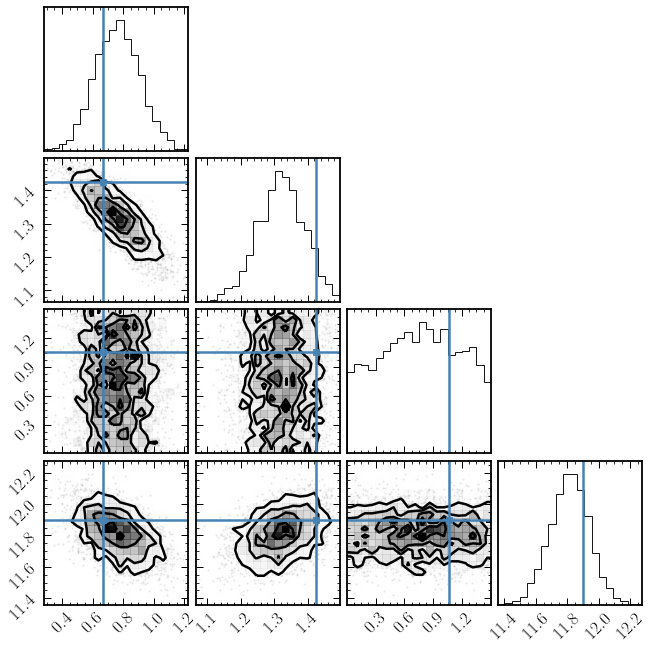

In [73]:
corner.corner(posterior_samples[:, 1:5], truths=theta_truth[1:5]);

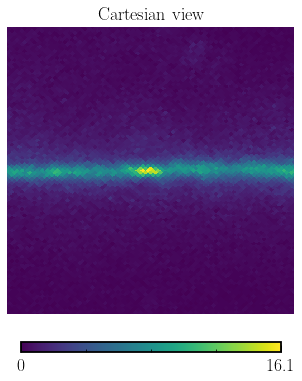

In [68]:
test_map = np.zeros(hp.nside2npix(128))
test_map[np.where(~masks_list[0])] = x_presimulated[51,0,:-1]
embed = hp.cartview(test_map, lonra=[-20,20], latra=[-20,20], return_projected_map=True);